In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from sklearn.model_selection import train_test_split

In [18]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph to match LPM0,2,4 on first 11 trials - maybe automate this later
doses = np.array([0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,43.52,48.96,54.4,59.84,0,5.44,10.88,16.32,21.76,27.2,32.64,38.08,43.52,48.96,54.4,59.84,0,2.72,5.44,8.16,10.88,13.6,16.32,19.04,21.76,24.48,27.2,29.92])
classes = ["0-25", "25+"]

In [19]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [20]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = np.arange(11)
channels = ["Channel1"]
modes = ["LPM0", "LPM2", "LPM4"]
trial_labels = [[f"{channel}/{mode}_Trial{number}" for number in trial_numbers for channel in channels] for mode in modes] #["Channel1/LPM0_Trial0", "Channel1/LPM0_Trial91"]
trials = [[pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()[::] for label in mode_labels] for mode_labels in trial_labels]

trial_slde_width = 1000
test_percent = .2
val_percent = .2 #percent of test set to be reserved for validation

#format data
train_label_values = list(doses)
data, data_y, train, train_y, test, test_y, val, val_y = ( [[] for _ in range(len(modes))] for _ in range(8) ) #setup with len(modes) empty arrays for each modes data
for i, mode_trials in enumerate(trials):
    for n, trial in enumerate(mode_trials):
        #normalize all values using z-score
        trial_copy = np.zeros(trial.shape)
        trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
        trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
        for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slde_width)[::trial_slde_width]:
            data[i].append(win)
            if train_label_values[n] > 25:
                data_y[i].append(1)
            else:
                data_y[i].append(0)

#split train/test/val
for mode in range(len(modes)):
    temp_train, temp_test, temp_train_y, temp_test_y = train_test_split(data[mode], data_y[mode], test_size = test_percent, random_state=2)
    temp_test, temp_val, temp_test_y, temp_val_y = train_test_split(temp_test, temp_test_y, test_size = val_percent, random_state=2)
    train[mode] = np.asarray(temp_train)
    train_y[mode] = np.asarray(temp_train_y)
    test[mode] = np.asarray(temp_test)
    test_y[mode] = np.asarray(temp_test_y)
    val[mode] = np.asarray(temp_val)
    val_y[mode] = np.asarray(temp_val_y)

trials = data = data_y = None #clear up some memory

In [34]:
#model creation
models = []
model = Sequential()

model.add(Conv1D(8, train[0].shape[1], activation="relu", padding='same', input_shape=(train[0].shape[1], 1),
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(8))

model.add(Conv1D(6, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(6))

model.add(Conv1D(4, train[0].shape[1], activation="relu", padding='same',
                 kernel_regularizer=keras.regularizers.l2(l=0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                ))
model.add(MaxPooling1D(4))

model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(2))

for mode in range(len(modes)):
    m = keras.models.clone_model(model)
    m.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
              metrics = ["accuracy"]) #each model has to be compiled seperatly
    models.append(m)



Training model 0 - (LPM0) 

Epoch 1/10
110/110 - 2s - loss: 1.7925 - accuracy: 0.6091 - val_loss: 1.5854 - val_accuracy: 0.6364
Epoch 2/10
110/110 - 1s - loss: 1.3248 - accuracy: 0.8091 - val_loss: 1.1542 - val_accuracy: 0.8182
Epoch 3/10
110/110 - 2s - loss: 0.9491 - accuracy: 0.9114 - val_loss: 0.8489 - val_accuracy: 0.8636
Epoch 4/10
110/110 - 1s - loss: 0.7412 - accuracy: 0.9091 - val_loss: 0.6849 - val_accuracy: 0.8636
Epoch 5/10
110/110 - 1s - loss: 0.6163 - accuracy: 0.9182 - val_loss: 0.6072 - val_accuracy: 0.8182
Epoch 6/10
110/110 - 1s - loss: 0.5391 - accuracy: 0.9159 - val_loss: 0.5031 - val_accuracy: 0.9545
Epoch 7/10
110/110 - 1s - loss: 0.4860 - accuracy: 0.9364 - val_loss: 0.4673 - val_accuracy: 0.9545
Epoch 8/10
110/110 - 2s - loss: 0.4343 - accuracy: 0.9295 - val_loss: 0.4347 - val_accuracy: 0.9545
Epoch 9/10
110/110 - 1s - loss: 0.4297 - accuracy: 0.9227 - val_loss: 0.4210 - val_accuracy: 0.9545
Epoch 10/10
110/110 - 1s - loss: 0.4271 - accuracy: 0.9227 - val_loss:

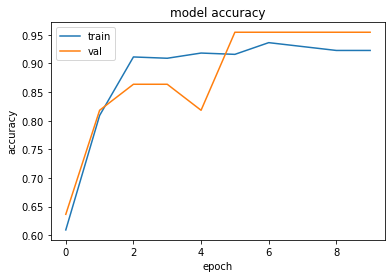

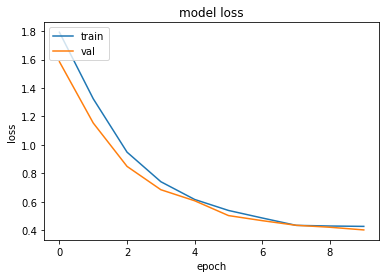



Training model 1 - (LPM2) 

Epoch 1/10
110/110 - 2s - loss: 1.7937 - accuracy: 0.6295 - val_loss: 1.5651 - val_accuracy: 0.8636
Epoch 2/10
110/110 - 1s - loss: 1.3063 - accuracy: 0.8159 - val_loss: 1.0055 - val_accuracy: 0.9091
Epoch 3/10
110/110 - 2s - loss: 0.8560 - accuracy: 0.9000 - val_loss: 0.6614 - val_accuracy: 0.9545
Epoch 4/10
110/110 - 1s - loss: 0.6484 - accuracy: 0.9068 - val_loss: 0.5037 - val_accuracy: 1.0000
Epoch 5/10
110/110 - 1s - loss: 0.5314 - accuracy: 0.9273 - val_loss: 0.4360 - val_accuracy: 0.9545
Epoch 6/10
110/110 - 1s - loss: 0.4684 - accuracy: 0.9182 - val_loss: 0.3588 - val_accuracy: 0.9545
Epoch 7/10
110/110 - 2s - loss: 0.4321 - accuracy: 0.9114 - val_loss: 0.3249 - val_accuracy: 1.0000
Epoch 8/10
110/110 - 1s - loss: 0.3935 - accuracy: 0.9205 - val_loss: 0.2974 - val_accuracy: 1.0000
Epoch 9/10
110/110 - 2s - loss: 0.3750 - accuracy: 0.9227 - val_loss: 0.2773 - val_accuracy: 0.9545
Epoch 10/10
110/110 - 2s - loss: 0.3639 - accuracy: 0.9159 - val_loss:

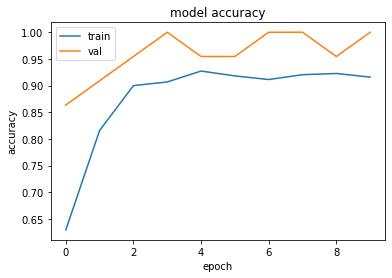

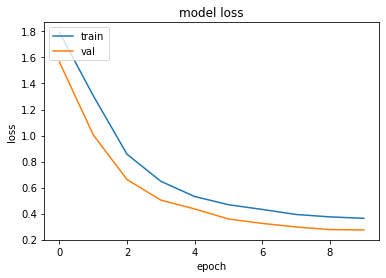



Training model 2 - (LPM4) 

Epoch 1/10
110/110 - 2s - loss: 1.7849 - accuracy: 0.6045 - val_loss: 1.5745 - val_accuracy: 0.5455
Epoch 2/10
110/110 - 2s - loss: 1.3444 - accuracy: 0.7341 - val_loss: 1.2651 - val_accuracy: 0.7727
Epoch 3/10
110/110 - 2s - loss: 1.0337 - accuracy: 0.8000 - val_loss: 1.0556 - val_accuracy: 0.7273
Epoch 4/10
110/110 - 2s - loss: 0.8668 - accuracy: 0.8045 - val_loss: 0.8877 - val_accuracy: 0.7727
Epoch 5/10
110/110 - 1s - loss: 0.7521 - accuracy: 0.8273 - val_loss: 0.7686 - val_accuracy: 0.7727
Epoch 6/10
110/110 - 1s - loss: 0.6594 - accuracy: 0.8318 - val_loss: 0.6976 - val_accuracy: 0.7727
Epoch 7/10
110/110 - 1s - loss: 0.6008 - accuracy: 0.8364 - val_loss: 0.6378 - val_accuracy: 0.8182
Epoch 8/10
110/110 - 2s - loss: 0.5785 - accuracy: 0.8114 - val_loss: 0.6316 - val_accuracy: 0.8636
Epoch 9/10
110/110 - 1s - loss: 0.5510 - accuracy: 0.8545 - val_loss: 0.5949 - val_accuracy: 0.8636
Epoch 10/10
110/110 - 1s - loss: 0.5293 - accuracy: 0.8364 - val_loss:

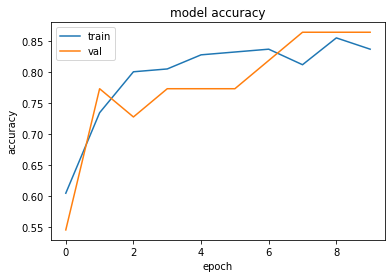

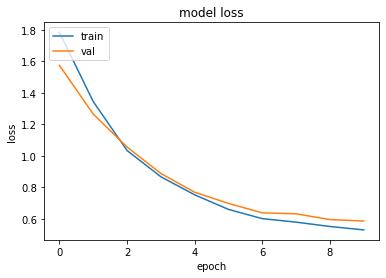

In [35]:
#train each model seperatly
#red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mean_squared_error", factor=0.1, patience=5, verbose=0, mode="auto", min_lr=0.001)
for n, model in enumerate(models):
    print(f"\n\nTraining model {n} - ({modes[n]}) \n")
    
    history = model.fit(train[n][..., None], train_y[n], batch_size=4, epochs=10, verbose=2, validation_data=(val[n][..., None], val_y[n]))
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [39]:
for mode in range(len(modes)):
    print(f"{modes[mode]} {models[mode].evaluate(test[mode][..., None], test_y[mode])}")

3/3 [==============================] - 0s 18ms/step - loss: 0.3479 - accuracy: 0.9659
LPM0 [0.3479308784008026, 0.9659090638160706]
3/3 [==============================] - 0s 17ms/step - loss: 0.3132 - accuracy: 0.9432
LPM2 [0.31317222118377686, 0.9431818127632141]
3/3 [==============================] - 0s 17ms/step - loss: 0.5161 - accuracy: 0.8636
LPM4 [0.5160917639732361, 0.8636363744735718]


In [40]:
for n, model in enumerate(models):
    model.save(f"models/classification_{modes[n]}.h5")

In [38]:
#show some predictions from test dataset
start = 40
predictions = 10
for mode in range(len(modes)):
    print(f"\nPredicting {predictions} values - ({modes[mode]}) \n")
    for n in range(start, start+predictions):
        print(f"\tPredicted: {np.argmax(models[mode](test[mode][n][None, ..., None]).numpy())}, expected: {test_y[mode][n]}")


Predicting 10 values - (LPM0) 

	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 0, expected: 0

Predicting 10 values - (LPM2) 

	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 0, expected: 0

Predicting 10 values - (LPM4) 

	Predicted: 0, expected: 0
	Predicted: 0, expected: 1
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 1, expected: 0
	Predicted: 0, expected: 0
	Predicted: 1, expected: 1
	Predicted: 0, expected: 0
	Predicted: 0, expected: 0
